# Simulation of respiratory control in vitro 

The integrated model developed in the previous section can be adapted to simulate in vitro experiments performed using suspensions of mitochondria purified from primary tissues. To simulate in vitro experiments, the major change that we make to the model is to replace the cytosolic components of the model with variables and associated volumes of distribution representing experimental buffers used in specific experiments. Here, we set $V_c = 1$, $V_m = 5\text{e-}4$, and $W_c = 1$ to represent mitochondria suspended in a buffer solution, i.e., in this virtual experiment, the mitochondria take up $0.05\%$ of the volume of the experimental media. 
    
The following code simulates an experiment in which the non-energized mitochondrial state (state 1), is followed by a leak state (state 2), followed by oxidative phosphorylation state (state 3), followed by another leak state (state 4) {cite}`Gnaiger2020`. The virtual experiment represents a real experiment in which a purified suspension of mitochondria is introduced to a buffer containing no fuel substrates at time $t=0$. This non-energized state is simulated by setting the dehydrogenase activity in the model to $X_{\rm DH} = 0$ for $0 \leq t < 25 \ \text{s}$. State 2 is achieved by setting $X_{\rm DH}$ to $0.1732$ for $25 \leq t < 75 \ \text{s}$ to represent the addition of substrates (such as pyruvate and malate) to fuel NADH production. At time $t = 75 \ \text{s}$, $0.375 \ \mu\text{M}$ of ADP is introduced into the respiration buffer to initiate the active oxidative phosphorylation state, or state 3. State 4 occurs when the ADP is nearly fully phosphorylated at approximately $t = 170 \ \text{s}$, and the system returns to a leak state. Note that this experiment is conducted under high external inorganic phosphate conditions (i.e.,   initial   $[\text{Pi}]_c = 5 \ \text{mM}$).

```{list-table} Isolated mitochondria in silico experiment.
:header-rows: 1
:name: table-invitro

* - Parameter or Condition 
  - State 1 
  - State 2 
  - State 3 and 4 		
* - $X_\text{DH}$ 
  - $0$ 
  - $0.1732$ 
  - $ - $ 
* - $[\text{NADH}]_x$ 
  - $0$ 
  - $-$ 
  - $-$
* - $[\text{ATP}]_c$ 
  - $0$ 
  - $-$ 
  - $-$ 
* - $[\text{ADP}]_c$ 
  - $0$ 
  - $ -$ 
  - $+375$ $\mu$M 
* - $[\text{Pi}]_c$ 
  - $5$ mM
  - $-$ 
  - $-$ 
```

In [1]:
import numpy as np
import matplotlib.pyplot as plt

!pip install scipy
from scipy.integrate import solve_ivp

###### Constants defining metabolite pools ######
# Volume fractions and water space fractions
V_c = 1.0          # buffer volume fraction        # L buffer (L cuvette)**(-1)
V_m = 0.0005       # mitochondrial volume fraction # L mito (L cuvette)**(-1)
V_m2c = V_m / V_c  # mito to cyto volume ratio     # L mito (L cuvette)**(-1)
W_c = 1.0          # buffer water space            # L buffer water (L buffer)**(-1)
W_m = 0.7238       # mitochondrial water space     # L mito water (L mito)**(-1)
W_x = 0.9*W_m      # matrix water space            # L matrix water (L mito)**(-1)
W_i = 0.1*W_m      # intermembrane water space     # L IM water (L mito)**(-1)

# Total pool concentrations
NAD_tot = 2.97e-3  # NAD+ and NADH conc            # mol (L matrix water)**(-1)
Q_tot   = 1.35e-3  # Q and QH2 conc                # mol (L matrix water)**(-1)
c_tot   = 2.7e-3   # cytochrome c ox and red conc  # mol (L IM water)**(-1)

# Membrane capacitance
Cm = 3.1e-3

###### Set fixed pH, cation concentrations, and O2 partial pressure ######
# pH
pH_x = 7.40
pH_c = 7.20

# K+ concentrations
K_x  = 100e-3      # mol (L matrix water)**(-1)
K_c  = 140e-3      # mol (L cyto water)**(-1)

# Mg2+ concentrations
Mg_x = 1.0e-3        # mol (L matrix water)**(-1)
Mg_c = 1.0e-3        # mol (L cyto water)**(-1)

# Oxygen partial pressure
PO2 = 25 # mmHg

###### Parameter vector ###### 
X_DH  = 0.1732
X_C1  = 1.0e4
X_C3  = 1.0e6
X_C4  = 0.0125
X_F   = 1.0e3
E_ANT = 0.325
E_PiC = 5.0e6
X_H   = 1.0e3
X_AtC = 0

activity_array = np.array([X_DH, X_C1, X_C3, X_C4, X_F, E_ANT, E_PiC, X_H, X_AtC])

###### Initial Conditions ######
# Membrane Potential
DPsi_0 = 175/1000      # V

# Matrix species
sumATP_x_0 = 0.5e-3        # mol (L matrix water)**(-1)
sumADP_x_0 = 9.5e-3        # mol (L matrix water)**(-1)
sumPi_x_0  = 0.3e-3        # mol (L matrix water)**(-1)
NADH_x_0   = 0             # mol (L matrix water)**(-1)
QH2_x_0    = 0.1 * Q_tot   # mol (L matrix water)**(-1)

# IMS species
cred_i_0 = 0.1 * c_tot # mol (L IMS water)**(-1)

# Cytosolic species
sumATP_c_0 = 0       # mol (L cyto water)^(-1)
sumADP_c_0 = 0       # mol (L cyto water)^(-1)
sumPi_c_0  = 5.0e-3  # mol (L cyto water)^(-1)

X_0 = np.array([DPsi_0, sumATP_x_0, sumADP_x_0, sumPi_x_0, NADH_x_0, QH2_x_0, cred_i_0, sumATP_c_0, sumADP_c_0, sumPi_c_0])

def dXdt(t, X, activity_array, solve_ode):
    # Unpack variables 
    DPsi, sumATP_x,sumADP_x, sumPi_x, NADH_x, QH2_x, cred_i, sumATP_c, sumADP_c, sumPi_c = X
    X_DH, X_C1, X_C3, X_C4, X_F, E_ANT, E_PiC, X_H, X_AtC = activity_array

    # Hydrogen ion concentration
    H_x = 10**(-pH_x) # mol (L matrix water)**(-1)
    H_c = 10**(-pH_c) # mol (L cuvette water)**(-1)

    # Oxygen concentration
    a_3  = 1.74e-6   # oxygen solubility in cuvette   # mol (L matrix water * mmHg)**(-1)
    O2_x = a_3*PO2   # mol (L matrix water)**(-1)

    # Thermochemical constants
    R = 8.314          # J (mol K)**(-1)
    T = 37 + 273.15    # K
    F = 96485          # C mol**(-1)
    
    # Proton motive force parameters (dimensionless)
    n_F  = 8/3
    n_C1 = 4
    n_C3 = 2
    n_C4 = 4
    
    # Dissociation constants
    K_MgATP = 10**(-3.88)
    K_HATP  = 10**(-6.33)
    K_KATP  = 10**(-1.02)
    K_MgADP = 10**(-3.00)
    K_HADP  = 10**(-6.26)
    K_KADP  = 10**(-0.89)
    K_MgPi  = 10**(-1.66)
    K_HPi   = 10**(-6.62)
    K_KPi   = 10**(-0.42)

    # Other concentrations computed from the state variables
    NAD_x = NAD_tot - NADH_x  ## mol (L matrix water)**(-1)
    Q_x   = Q_tot - QH2_x     ## mol (L matrix water)**(-1)
    cox_i = c_tot - cred_i    ## mol (L matrix water)**(-1)

    ## Binding polynomials
    # Matrix species # mol (L mito water)**(-1)
    PATP_x = 1 + H_x/K_HATP + Mg_x/K_MgATP + K_x/K_KATP
    PADP_x = 1 + H_x/K_HADP + Mg_x/K_MgADP + K_x/K_KADP
    PPi_x  = 1 + H_x/K_HPi  + Mg_x/K_MgPi  + K_x/K_KPi
    
    # Cytosol species # mol (L cuvette water)**(-1)
    PATP_c = 1 + H_c/K_HATP + Mg_c/K_MgATP + K_c/K_KATP
    PADP_c = 1 + H_c/K_HADP + Mg_c/K_MgADP + K_c/K_KADP
    PPi_c  = 1 + H_c/K_HPi  + Mg_c/K_MgPi  + K_c/K_KPi
    
    ## Unbound species
    # Matrix species
    ATP_x = sumATP_x / PATP_x # [ATP4-]_x
    ADP_x = sumADP_x / PADP_x # [ADP3-]_x
    Pi_x  = sumPi_x  / PPi_x  # [HPO42-]_x
    
    # Cytosolic species 
    ATP_c = sumATP_c / PATP_c # [ATP4-]_c
    ADP_c = sumADP_c / PADP_c # [ADP3-]_c
    Pi_c  = sumPi_c  / PPi_c  # [HPO42-]_c
    
    
    ###### NADH Dehydrogenase ######
    # Constants
    r      = 6.8385
    k_Pi1  = 4.659e-4    # mol (L matrix water)**(-1)
    k_Pi2  = 6.578e-4    # mol (L matrix water)**(-1)
    
    # Flux (mol (s * L mito)**(-1))
    J_DH = X_DH * (r * NAD_x - NADH_x) * ((1 + sumPi_x / k_Pi1) / (1+sumPi_x / k_Pi2))

    ###### Complex I ######
    # NADH_x + Q_x + 5H+_x <-> NAD+_x + QH2_x + 4H+_i + 4DPsi
    
    # Gibbs energy (J mol**(-1))
    DrGo_C1 = -109680 
    DrGapp_C1 = DrGo_C1 - R * T * np.log(H_x) 
    
    # Apparent equilibrium constant 
    Kapp_C1   = np.exp( -(DrGapp_C1 + n_C1 * F * DPsi) / (R * T)) * ((H_x / H_c)**n_C1)
    
    # Flux (mol (s * L mito)**(-1))
    J_C1 = X_C1 * (Kapp_C1 * NADH_x * Q_x - NAD_x * QH2_x)
    
    ###### Complex III ######
    # QH2_x + 2cuvetteC(ox)3+_i + 2H+_x <-> Q_x + 2cuvetteC(red)2+_i + 4H+_i + 2DPsi
    
    # Gibbs energy (J mol**(-1))
    DrGo_C3 = 46690 
    DrGapp_C3 = DrGo_C3 + 2 * R * T * np.log(H_c) 
    
    # Apparent equilibrium constant 
    Kapp_C3   = np.exp(-(DrGapp_C3 + n_C3 * F * DPsi) / (R * T)) * (H_x / H_c)**n_C3 
    
    # Flux (mol (s * L mito)**(-1))
    J_C3 = X_C3 * (Kapp_C3 * cox_i**2 * QH2_x - cred_i**2 * Q_x)

    ###### Complex IV ######
    # 2 cytoC(red)2+_i + 0.5O2_x + 4H+_x <-> cytoC(ox)3+_x + H2O_x + 2H+_i +2DPsi
    
    # Constant
    k_O2 = 1.2e-4      # mol (L matrix water)**(-1)
    
    # Gibbs energy (J mol**(-1))
    DrGo_C4 = -202160  # J mol**(-1)
    DrGapp_C4 = DrGo_C4 - 2 * R * T * np.log(H_c)
    
    # Apparent equilibrium constant 
    Kapp_C4   = np.exp(-(DrGapp_C4 + n_C4 * F * DPsi) / (R * T)) * (H_x / H_c)**n_C4
    
    # Flux (mol (s * L mito)**(-1))
    J_C4 = X_C4 *(Kapp_C4**0.5 * cred_i * O2_x**0.25 - cox_i) * (1 / (1 + k_O2 / O2_x))

    ###### F0F1-ATPase ######
    # ADP3-_x + HPO42-_x + H+_x + n_A*H+_i <-> ATP4- + H2O + n_A*H+_x
    
    # Gibbs energy (J mol**(-1))
    DrGo_F = 4990 
    DrGapp_F = DrGo_F + R * T * np.log( H_x * PATP_x / (PADP_x * PPi_x))
    
    # Apparent equilibrium constant
    Kapp_F   = np.exp( (DrGapp_F + n_F * F * DPsi ) / (R * T)) * (H_c / H_x)**n_F
    
    # Flux (mol (s * L mito)**(-1))
    J_F = X_F * (Kapp_F * sumADP_x * sumPi_x - sumATP_x)
    
    ###### ANT ######
    # ATP4-_x + ADP3-_i <-> ATP4-_i + ADP3-_x
    
    # Constants 
    del_D   = 0.0167
    del_T   = 0.0699
    k2o_ANT = 9.54/60      # s**(-1)
    k3o_ANT = 30.05/60     # s**(-1)
    K0o_D   = 38.89e-6     # mol (L cuvette water)**(-1)
    K0o_T   = 56.05e-6     # mol (L cuvette water)**(-1)
    A       = +0.2829
    B       = -0.2086
    C       = +0.2372
    
    phi = F * DPsi / (R * T)
    
    # Reaction rates
    k2_ANT = k2o_ANT * np.exp((A*(-3) + B*(-4) + C)*phi)
    k3_ANT = k3o_ANT * np.exp((A*(-4) + B*(-3) + C)*phi)
    
    # Dissociation constants
    K0_D = K0o_D * np.exp(3*del_D*phi)
    K0_T = K0o_T * np.exp(4*del_T*phi)
    
    q     = k3_ANT * K0_D * np.exp(phi) / (k2_ANT * K0_T)
    term1 = k2_ANT * ATP_x * ADP_c * q / K0_D
    term2 = k3_ANT * ADP_x * ATP_c / K0_T
    num   = term1 - term2
    den   = (1 + ATP_c/K0_T + ADP_c/K0_D) * (ADP_x + ATP_x * q)
    
    # Flux (mol (s * L mito)**(-1))
    J_ANT = E_ANT * num / den
    
    ###### H+-PI2 cotransporter ######
    # H2PO42-_x + H+_x = H2PO42-_c + H+_c
    
    # Constant
    k_PiC = 1.61e-3  # mol (L cuvette)**(-1)
    
    # H2P04- species
    HPi_c = Pi_c * (H_c / K_HPi)
    HPi_x = Pi_x * (H_x / K_HPi)
    
    # Flux (mol (s * L mito)**(-1))
    J_PiC = E_PiC * (H_c * HPi_c - H_x * HPi_x) / (k_PiC + HPi_c)

    ###### H+ leak ######
    
    # Flux (mol (s * L mito)**(-1))
    J_H = X_H * (H_c * np.exp(phi/2) - H_x * np.exp(-phi/2))
    
    ###### ATPase ######
    # ATP4- + H2O = ADP3- + PI2- + H+
    
    #Flux (mol (s * L cyto)**(-1))
    J_AtC = X_AtC / V_c

    ###### Differential equations (equation 23) ######
    # Membrane potential
    dDPsi = (n_C1 * J_C1 + n_C3 * J_C3 + n_C4 * J_C4 - n_F * J_F - J_ANT - J_H) / Cm

    # Matrix species
    dATP_x  = (J_F  - J_ANT) / W_x
    dADP_x  = (-J_F + J_ANT) / W_x
    dPi_x   = (-J_F + J_PiC) / W_x
    dNADH_x = (J_DH  - J_C1)  / W_x
    dQH2_x  = (J_C1  - J_C3)  / W_x
    
    # IMS species
    dcred_i = 2 * (J_C3 - J_C4) / W_i
    
    # Buffer species
    dATP_c = ( V_m2c * J_ANT - J_AtC ) / W_c
    dADP_c = (-V_m2c * J_ANT + J_AtC ) / W_c
    dPi_c  = (-V_m2c * J_PiC + J_AtC) / W_c

    dX = [dDPsi, dATP_x, dADP_x, dPi_x, dNADH_x, dQH2_x, dcred_i, dATP_c, dADP_c, dPi_c]
    
    # Calculate state-dependent quantities after model is solved. 
    if solve_ode == 1:
        return dX
    else:
        J = np.array([PATP_x, PADP_x, PPi_x, PATP_c, PADP_c, PPi_c, J_DH, J_C1, J_C3, J_C4, J_F, J_ANT, J_PiC])
        return dX, J

### Four State Model ###
# State 1 - no substrates
t_1 = np.linspace(0,25,25*2)
X_AtC = 0.
X_DH = 0.001 # Kept non-zero for solver stability
activity_array = np.array([X_DH, X_C1, X_C3, X_C4, X_F, E_ANT, E_PiC, X_H, X_AtC])
state_1_results = solve_ivp(dXdt, [0,25], X_0, method = 'Radau', t_eval = t_1, args=(activity_array,1,))

# State 2 - Add substrate (i.e. turn on X_DH)
t_2 = np.linspace(25,75,(75 - 25)*2)
X_DH = 0.0866 * 2
activity_array = np.array([X_DH, X_C1, X_C3, X_C4, X_F, E_ANT, E_PiC, X_H, X_AtC])
state_2_results = solve_ivp(dXdt, [25,75], state_1_results.y[:,-1], method = 'Radau', t_eval = t_2, args=(activity_array,1,))

# State 3 and 4 - Add ADP
t_3 = np.linspace(75,200,(200 - 75)*2)
state_2_results.y[8, -1] = 0.375e-3 # Molar
state_3_results = solve_ivp(dXdt, [75,200], state_2_results.y[:,-1], method = 'Radau', t_eval = t_3, args=(activity_array,1,))

# Concatenate Results
# Note: remove redundant time points 
all_results = np.hstack((state_1_results.y[:,0:-1], state_2_results.y[:,0:-1],state_3_results.y))
t = np.concatenate((state_1_results.t[0:-1], state_2_results.t[0:-1], state_3_results.t))

DPsi, sumATP_x, sumADP_x, sumPi_x, NADH_x, QH2_x, cred_i, sumATP_c, sumADP_c, sumPi_c = all_results


# Calculate complex IV Flux
J_C4 = np.zeros(len(t))
for i in range(len(t)):
    dX, J = dXdt(t[i], all_results[:,i], activity_array, 0)
    J_C4[i] = J[9]

# Convert complex IV flux to oxygen flux in nmol O2 / U citrate synthase
JO2 = J_C4/2 * 60 * 1e9 * 0.0000012232



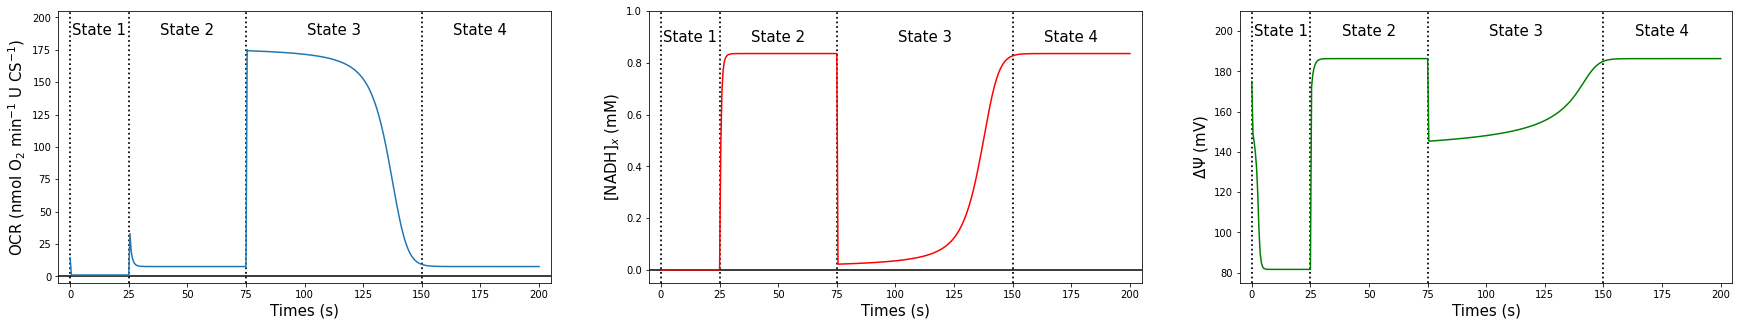

In [2]:
fig, ax = plt.subplots(1,3, figsize = (30,5))

ax[0].plot((-5,205),(0,0),'k')
ax[0].plot((0,0),(-5,205),'k:', linewidth = 1.75)
ax[0].plot((25,25),(-5,205),'k:', linewidth = 1.75)
ax[0].plot((75,75),(-5,205),'k:', linewidth = 1.75)
ax[0].plot((150,150),(-5,205),'k:', linewidth = 1.75)
ax[0].plot(t, JO2)
ax[0].set_ylim([-5,205])
ax[0].set_xlim([-5,205])
ax[0].text(12.5, 190, 'State 1', horizontalalignment='center', verticalalignment='center', fontsize = 15)
ax[0].text(50, 190, 'State 2', horizontalalignment='center', verticalalignment='center', fontsize = 15)
ax[0].text(112.5, 190, 'State 3', horizontalalignment='center', verticalalignment='center', fontsize = 15)
ax[0].text(175, 190, 'State 4', horizontalalignment='center', verticalalignment='center', fontsize = 15)
ax[0].set_xlabel('Times (s)', fontsize = 15)
ax[0].set_ylabel('OCR (nmol O$_2$ min$^{-1}$ U CS$^{-1}$)', fontsize = 15)

ax[1].plot((-5,205),(0,0),'k')
ax[1].plot((0,0),(-0.05,1),'k:', linewidth = 1.75)
ax[1].plot((25,25),(-0.05,1),'k:', linewidth = 1.75)
ax[1].plot((75,75),(-0.05,1),'k:', linewidth = 1.75)
ax[1].plot((150,150),(-0.05,1),'k:', linewidth = 1.75)
ax[1].plot(t, NADH_x/NAD_tot,'r')
ax[1].set_ylim([-0.05,1])
ax[1].set_xlim([-5,205])
ax[1].text(12.5, 0.9, 'State 1', horizontalalignment='center', verticalalignment='center', fontsize = 15)
ax[1].text(50, .9, 'State 2', horizontalalignment='center', verticalalignment='center', fontsize = 15)
ax[1].text(112.5, .9, 'State 3', horizontalalignment='center', verticalalignment='center', fontsize = 15)
ax[1].text(175, .9, 'State 4', horizontalalignment='center', verticalalignment='center', fontsize = 15)
ax[1].set_xlabel('Times (s)', fontsize = 15)
ax[1].set_ylabel('[NADH]$_x$ (mM)', fontsize = 15)

ax[2].plot((0,0),(75,210),'k:', linewidth = 1.75)
ax[2].plot((25,25),(75,210),'k:', linewidth = 1.75)
ax[2].plot((75,75),(75,210),'k:', linewidth = 1.75)
ax[2].plot((150,150),(75,210),'k:', linewidth = 1.75)
ax[2].plot(t, DPsi*1000,'g')
ax[2].set_ylim([75,210])
ax[2].set_xlim([-5,205])
ax[2].text(12.5, 200, 'State 1', horizontalalignment='center', verticalalignment='center', fontsize = 15)
ax[2].text(50, 200, 'State 2', horizontalalignment='center', verticalalignment='center', fontsize = 15)
ax[2].text(112.5, 200, 'State 3', horizontalalignment='center', verticalalignment='center', fontsize = 15)
ax[2].text(175, 200, 'State 4', horizontalalignment='center', verticalalignment='center', fontsize = 15)
ax[2].set_xlabel('Times (s)', fontsize = 15)
ax[2].set_ylabel('$\Delta \Psi$ (mV)', fontsize = 15)

plt.show()

**Figure 8:** Simulation of respiratory control for (a) the oxygen consumption rate (OCR), (b) matrix NADH concentration ($[\text{NADH}]_x$), and (c) membrane potential ($\Delta \Psi$) using the conditions listed in Table {numref}`table-invitro`.

The first panel in the above figures shows oxygen consumption rate (OCR), which represents the oxidative flux necessary to balance proton leak across the IMM. In this study, we quantify OCR in units $\text{nmol O}_2 \text{ min}^{-1} \text{ U CS}^{-1}$ proportional to the flux of complex IV, that is, 
```{math}
    J_\text{O2} = \Bigg( J_\text{C4} \ \dfrac{\text{mol}}{\text{s (L mito)}} \Bigg) \Bigg(60 \ \dfrac{\text{s}}{\text{min}} \Bigg)\Bigg(1\text{e}9 \ \dfrac{\text{nmol}}{\text{mol}}\Bigg)\Bigg(1.22\text{e-6} \ \dfrac{\text{L mito}}{\text{U CS}}\Bigg). 
```
The factor $1.22\text{e-}6 \text{ (L mito) (U CS)}^{-1}$ corresponds to roughly $740 \text{ (U CS) (mL mito)}^{-1}$, reported by Vinnakota et al. {cite}`Vinnakota2016_2`. Note that this approximation for $J_\text{O2}$ is valid for constant partial pressure of $\text{O}_2$, and hence, we do not model hypoxic or hyperoxic conditions. During the leak states, NADH and $\Delta\Psi$ are maintained at a maximal values. During state 3 (oxidative phosphorylation), the OCR markedly increases while the magnitudes of NADH and $\Delta\Psi$ are temporarily decreased. This simple model overestimates the degree to which the NADH becomes depleted during state 3.

Predictions of the in vitro model may also be compared to quasi-steady state data on OCRs, phosphate metabolite levels, $\Delta\Psi$, NADH, and cytochrome c redox state, analyzed by Bazil et al. {cite}`Bazil2016`. In their experiments, several steady state ATP demand levels were achieved by titrating ATP hydrolyzing enzymes into the respiration buffer. We simulate this experiment with our model by varying the rate of the external ATP consuming process, $J_\text{AtC}$. We vary $J_\text{AtC}$ by adjusting the ATP consumption rate $X_\text{AtC}$ from $0$ to $60 \ \text{mol s}^{-1} \ \text{(L cell)}^{-1}$. Experiments were conducted under conditions of two different approximately constant external phosphate concentrations (1 and 5 mM) and with external $\text{TAN} = 5 \ \text{mM}$. The following code computes the steady state of the in vitro model at different levels of $J_\text{AtC}$ and compares the measured data on OCR, $\Delta\Psi$, NADH, cytochrome c redox state, and buffer ADP concentration to data.

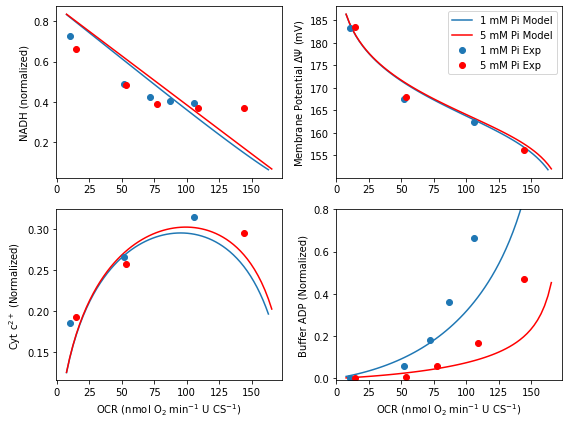

In [3]:
import numpy as np
import matplotlib.pyplot as plt

!pip install scipy
from scipy.integrate import solve_ivp

###### Constants defining metabolite pools ######
# Volume fractions and water space fractions
V_c = 1.0          # buffer volume fraction        # L buffer (L cuvette)**(-1)
V_m = 0.0005       # mitochondrial volume fraction # L mito (L cuvette)**(-1)
V_m2c = V_m / V_c  # mito to cyto volume ratio     # L mito (L cuvette)**(-1)
W_c = 1.0          # buffer water space            # L buffer water (L buffer)**(-1)
W_m = 0.7238       # mitochondrial water space     # L mito water (L mito)**(-1)
W_x = 0.9*W_m      # matrix water space            # L matrix water (L mito)**(-1)
W_i = 0.1*W_m      # intermembrane water space     # L IM water (L mito)**(-1)

# Total pool concentrations
NAD_tot = 2.97e-3  # NAD+ and NADH conc            # mol (L matrix water)**(-1)
Q_tot   = 1.35e-3  # Q and QH2 conc                # mol (L matrix water)**(-1)
c_tot   = 2.7e-3   # cytochrome c ox and red conc  # mol (L IM water)**(-1)

# Membrane capacitance
Cm = 3.1e-3

###### Set fixed pH, cation concentrations, and O2 partial pressure ######
# pH
pH_x = 7.40
pH_c = 7.20

# K+ concentrations
K_x  = 100e-3      # mol (L matrix water)**(-1)
K_c  = 140e-3      # mol (L cyto water)**(-1)

# Mg2+ concentrations
Mg_x = 1.0e-3        # mol (L matrix water)**(-1)
Mg_c = 1.0e-3        # mol (L cyto water)**(-1)

# Oxygen partial pressure
PO2 = 25 # mmHg

conc = np.array([pH_x, pH_c, K_x, K_c, Mg_x, Mg_c, PO2])

###### Parameter vector ###### 
X_DH  = 0.1732
X_C1  = 1.0e4
X_C3  = 1.0e6
X_C4  = 0.0125
X_F   = 1.0e3
E_ANT = 0.325
E_PiC = 5.0e6
X_H   = 1.0e3
X_AtC = 0

activity_array = np.array([X_DH, X_C1, X_C3, X_C4, X_F, E_ANT, E_PiC, X_H, X_AtC])

def dXdt(t, X, activity_array, solve_ode):
    # Unpack variables 
    DPsi, sumATP_x,sumADP_x, sumPi_x, NADH_x, QH2_x, cred_i, sumATP_c, sumADP_c, sumPi_c = X
    X_DH, X_C1, X_C3, X_C4, X_F, E_ANT, E_PiC, X_H, X_AtC = activity_array

    # Hydrogen ion concentration
    H_x = 10**(-pH_x) # mol (L matrix water)**(-1)
    H_c = 10**(-pH_c) # mol (L cuvette water)**(-1)

    # Oxygen concentration
    a_3  = 1.74e-6   # oxygen solubility in cuvette   # mol (L matrix water * mmHg)**(-1)
    O2_x = a_3*PO2   # mol (L matrix water)**(-1)

    # Thermochemical constants
    R = 8.314          # J (mol K)**(-1)
    T = 37 + 273.15    # K
    F = 96485          # C mol**(-1)
    
    # Proton motive force parameters (dimensionless)
    n_F  = 8/3
    n_C1 = 4
    n_C3 = 2
    n_C4 = 4
    
    # Dissociation constants
    K_MgATP = 10**(-3.88)
    K_HATP  = 10**(-6.33)
    K_KATP  = 10**(-1.02)
    K_MgADP = 10**(-3.00)
    K_HADP  = 10**(-6.26)
    K_KADP  = 10**(-0.89)
    K_MgPi  = 10**(-1.66)
    K_HPi   = 10**(-6.62)
    K_KPi   = 10**(-0.42)

    ## Other concentrations computed from the state variables:
    NAD_x = NAD_tot - NADH_x  # mol (L matrix water)**(-1)
    Q_x   = Q_tot - QH2_x     # mol (L matrix water)**(-1)
    cox_i = c_tot - cred_i    # mol (L matrix water)**(-1)

    ## Binding polynomials
    # Matrix species # mol (L mito water)**(-1)
    PATP_x = 1 + H_x/K_HATP + Mg_x/K_MgATP + K_x/K_KATP
    PADP_x = 1 + H_x/K_HADP + Mg_x/K_MgADP + K_x/K_KADP
    PPi_x  = 1 + H_x/K_HPi  + Mg_x/K_MgPi  + K_x/K_KPi
    
    # Cytosol species # mol (L cuvette water)**(-1)
    PATP_c = 1 + H_c/K_HATP + Mg_c/K_MgATP + K_c/K_KATP
    PADP_c = 1 + H_c/K_HADP + Mg_c/K_MgADP + K_c/K_KADP
    PPi_c  = 1 + H_c/K_HPi  + Mg_c/K_MgPi  + K_c/K_KPi
    
    ## Unbound species
    # Matrix species
    ATP_x = sumATP_x / PATP_x # [ATP4-]_x
    ADP_x = sumADP_x / PADP_x # [ADP3-]_x
    Pi_x  = sumPi_x  / PPi_x  # [HPO42-]_x
    
    # Cytosol species
    ATP_c = sumATP_c / PATP_c # [ATP4-]_c
    ADP_c = sumADP_c / PADP_c # [ADP3-]_c
    Pi_c  = sumPi_c  / PPi_c  # [HPO42-]_c
    
    
    ###### NADH Dehydrogenase ######
    # Constants
    r      = 6.8385
    k_Pi1  = 4.659e-4    # mol (L matrix water)**(-1)
    k_Pi2  = 6.578e-4    # mol (L matrix water)**(-1)
    
    # Flux
    J_DH = X_DH * (r * NAD_x - NADH_x) * ((1 + sumPi_x / k_Pi1) / (1+sumPi_x / k_Pi2))

    ###### Complex I ######
    # NADH_x + Q_x + 5H+_x <-> NAD+_x + QH2_x + 4H+_i + 4DPsi
    
    # Gibbs energy (J mol**(-1))
    DrGo_C1 = -109680 
    DrGapp_C1 = DrGo_C1 - R * T * np.log(H_x) 
    
    # Apparent equilibrium constant
    Kapp_C1   = np.exp( -(DrGapp_C1 + n_C1 * F * DPsi) / (R * T)) * ((H_x / H_c)**n_C1)
    
    # Flux (mol (s * L mito)**(-1))
    J_C1 = X_C1 * (Kapp_C1 * NADH_x * Q_x - NAD_x * QH2_x)
    
    ###### Complex III ######
    # QH2_x + 2cuvetteC(ox)3+_i + 2H+_x <-> Q_x + 2cuvetteC(red)2+_i + 4H+_i + 2DPsi
    
    # Gibbs energy (J mol**(-1))
    DrGo_C3 = 46690
    DrGapp_C3 = DrGo_C3 + 2 * R * T * np.log(H_c) 
    
    # Apparent equilibrium constant
    Kapp_C3   = np.exp(-(DrGapp_C3 + n_C3 * F * DPsi) / (R * T)) * (H_x / H_c)**n_C3 
    
    # Flux (mol (s * L mito)**(-1))
    J_C3 = X_C3 * (Kapp_C3 * cox_i**2 * QH2_x - cred_i**2 * Q_x)

    ###### Complex IV ######
    # 2 cytoC(red)2+_i + 0.5O2_x + 4H+_x <-> cytoC(ox)3+_x + H2O_x + 2H+_i + 2DPsi
    
    # Constants
    k_O2 = 1.2e-4      # mol (L matrix water)**(-1)
    
    # Gibbs energy (J mol**(-1))
    DrGo_C4 = -202160  # J mol**(-1)
    DrGapp_C4 = DrGo_C4 - 2 * R * T * np.log(H_c)
    
    # Apparent equilibrium constant
    Kapp_C4   = np.exp(-(DrGapp_C4 + n_C4 * F * DPsi) / (R * T)) * (H_x / H_c)**n_C4
    
    # Flux (mol (s * L mito)**(-1))
    J_C4 = X_C4 *(Kapp_C4**0.5 * cred_i * O2_x**0.25 - cox_i) * (1 / (1 + k_O2 / O2_x))

    ###### F0F1-ATPase ######
    # ADP3-_x + HPO42-_x + H+_x + n_A*H+_i <-> ATP4- + H2O + n_A*H+_x
    
    # Gibbs energy (J mol**(-1))
    DrGo_F = 4990 
    DrGapp_F = DrGo_F + R * T * np.log( H_x * PATP_x / (PADP_x * PPi_x))
    
    # Apparent equilibrium constant
    Kapp_F   = np.exp( (DrGapp_F + n_F * F * DPsi ) / (R * T)) * (H_c / H_x)**n_F
    
    # Flux (mol (s * L mito)**(-1))
    J_F = X_F * (Kapp_F * sumADP_x * sumPi_x - sumATP_x)
    
    ###### ANT ######
    # ATP4-_x + ADP3-_i <-> ATP4-_i + ADP3-_x
    
    # Constants
    del_D   = 0.0167
    del_T   = 0.0699
    k2o_ANT = 9.54/60      # s**(-1)
    k3o_ANT = 30.05/60     # s**(-1)
    K0o_D   = 38.89e-6     # mol (L cuvette water)**(-1)
    K0o_T   = 56.05e-6     # mol (L cuvette water)**(-1)
    A       = +0.2829
    B       = -0.2086
    C       = +0.2372
    
    phi = F * DPsi / (R * T)
    
    # Reaction rates
    k2_ANT = k2o_ANT * np.exp((A*(-3) + B*(-4) + C)*phi)
    k3_ANT = k3o_ANT * np.exp((A*(-4) + B*(-3) + C)*phi)
    
    # Dissociation constants
    K0_D = K0o_D * np.exp(3*del_D*phi)
    K0_T = K0o_T * np.exp(4*del_T*phi)
    
    q     = k3_ANT * K0_D * np.exp(phi) / (k2_ANT * K0_T)
    term1 = k2_ANT * ATP_x * ADP_c * q / K0_D
    term2 = k3_ANT * ADP_x * ATP_c / K0_T
    num   = term1 - term2
    den   = (1 + ATP_c/K0_T + ADP_c/K0_D) * (ADP_x + ATP_x * q)
    
    # Flux (mol (s * L mito)**(-1))
    J_ANT = E_ANT * num / den
    
    ###### H+-PI2 cotransporter ######
    # H2PO42-_x + H+_x = H2PO42-_c + H+_c
    
    # Constant
    k_PiC = 1.61e-3  # mol (L cuvette)**(-1)
    
    # H2P04- species
    HPi_c = Pi_c * (H_c / K_HPi)
    HPi_x = Pi_x * (H_x / K_HPi)
    
    # Flux (mol (s * L mito)**(-1))
    J_PiC = E_PiC * (H_c * HPi_c - H_x * HPi_x) / (k_PiC + HPi_c)

    ###### H+ leak ######
    
    # Flux (mol (s * L mito)**(-1))
    J_H = X_H * (H_c * np.exp(phi/2) - H_x * np.exp(-phi/2))
    
    ###### ATPase ######
    # ATP4- + H2O = ADP3- + PI2- + H+
    
    #Flux (mol (s * L cyto)**(-1))
    J_AtC = X_AtC / V_c

    ###### Differential equations (equation 23) ######
    # Membrane potential
    dDPsi = (n_C1 * J_C1 + n_C3 * J_C3 + n_C4 * J_C4 - n_F * J_F - J_ANT - J_H) / Cm

    # Matrix species
    dATP_x  = (J_F  - J_ANT) / W_x
    dADP_x  = (-J_F + J_ANT) / W_x
    dPi_x   = (-J_F + J_PiC) / W_x
    dNADH_x = (J_DH  - J_C1)  / W_x
    dQH2_x  = (J_C1  - J_C3)  / W_x
    
    # IMS species
    dcred_i = 2 * (J_C3 - J_C4) / W_i
    
    # Buffer species
    dATP_c = ( V_m2c * J_ANT - J_AtC ) / W_c
    dADP_c = (-V_m2c * J_ANT + J_AtC ) / W_c
    dPi_c  = (-V_m2c * J_PiC + J_AtC) / W_c

    dX = [dDPsi, dATP_x, dADP_x, dPi_x, dNADH_x, dQH2_x, dcred_i, dATP_c, dADP_c, dPi_c]
    
    # Calculate state-dependent quantities after model is solved.
    if solve_ode == 1:
        return dX
    else:
        J = np.array([PATP_x, PADP_x, PPi_x, PATP_c, PADP_c, PPi_c, J_DH, J_C1, J_C3, J_C4, J_F, J_ANT, J_PiC])
        return dX, J


###### Run Low Pi experiments ######

# Membrane potential
DPsi_0 = 175*1e-3

# Matrix species
ATP_x_0  = 0.5e-3
ADP_x_0  = 9.5e-3
Pi_x_0   = 0.3e-3
NADH_x_0 = 0.1 * NAD_tot
QH2_x_0  = 0.1 * Q_tot

# IMS species
cred_i_0 = 0.1 * c_tot

# Cytosol species
ATP_c_0 = 5.0e-3
ADP_c_0 = 0.0e-3
Pi_c_0  = 1.0e-3

X_0 = np.array([DPsi_0, ATP_x_0, ADP_x_0, Pi_x_0, NADH_x_0, QH2_x_0, cred_i_0, ATP_c_0, ADP_c_0, Pi_c_0 ])

# Range of ATP consumption rates
X_AtC = np.linspace(0,6e-6, 60)   
steady_state = np.zeros((len(X_AtC), len(X_0)))
JO2 = np.zeros(len(X_AtC))

# Looping through different ATP consumptions states
for i in range(len(X_AtC)):
   activity_array = np.array([X_DH, X_C1, X_C3, X_C4, X_F, E_ANT, E_PiC, X_H, X_AtC[i]])
   # run for long time to acheive steady-state
   steady_state_temp_results = solve_ivp(dXdt, [0,3000], X_0, method = 'Radau', args=(activity_array,1,)).y[:,-1]
   steady_state[i] = steady_state_temp_results
   f,J = dXdt(3000,steady_state_temp_results, activity_array, 0)
   J_C4 = J[9] # oxygen flux in mol O / sec / (L mito)

   # convert to units of nmol / min / UCS
   # using the conversion factor 0.0012232 mL of mito per UCS
   JO2[i] = J_C4/2 * 60 * 1e9 * 0.0000012232

DPsi_low_pi, ATP_x_low_pi, ADP_x_low_pi, Pi_x_low_pi, NADH_x_low_pi, QH2_x_low_pi, cred_i_low_pi, ATP_c_low_pi, ADP_c_low_pi, Pi_c_low_pi = steady_state.T
fig, ax = plt.subplots(2,2, figsize = (8,6))

# Low Pi Plotting  Plotting
ax[0,0].plot(JO2, NADH_x_low_pi/NAD_tot, 'C0')   # NADH
ax[0,1].plot(JO2, DPsi_low_pi * 1000, 'C0', label = '1 mM Pi Model')      # Membrane Potential
ax[1,0].plot(JO2, cred_i_low_pi/c_tot,'C0')      # Cytochrome C
ax[1,1].plot(JO2, ADP_c_low_pi * 1000, 'C0')     # ADP

###### Running High Pi experiments ######
 
# Membrane potential
DPsi_0 = 175*1e-3

# Matrix species
ATP_x_0  = 0.5e-3
ADP_x_0  = 9.5e-3
Pi_x_0   = 0.3e-3
NADH_x_0 = 0.1 * NAD_tot
QH2_x_0  = 0.1 * Q_tot

# IM species
cred_i_0 = 0.1 * c_tot

# Cytosol species
ATP_c_0 = 5.0e-3
ADP_c_0 = 0.0e-3
Pi_c_0  = 5.0e-3

X_0 = np.array([DPsi_0, ATP_x_0, ADP_x_0, Pi_x_0, NADH_x_0, QH2_x_0, cred_i_0, ATP_c_0, ADP_c_0, Pi_c_0 ])

# Range of ATP consumption rates
X_AtC = np.linspace(0,6e-6, 60)   
steady_state = np.zeros((len(X_AtC), len(X_0)))
JO2 = np.zeros(len(X_AtC))

# Looping through different ATP consumptions states
for i in range(len(X_AtC)):
   activity_array = np.array([X_DH, X_C1, X_C3, X_C4, X_F, E_ANT, E_PiC, X_H, X_AtC[i]])
   # run for long time to acheive steady-state
   steady_state_temp_results = solve_ivp(dXdt, [0,3000], X_0, method = 'Radau', args=(activity_array,1,)).y[:,-1]
   steady_state[i] = steady_state_temp_results
   f,J = dXdt(3000,steady_state_temp_results, activity_array, 0)
   J_C4 = J[9] # oxygen flux in mol O / sec / (L mito)

   # convert to units of nmol / min / UCS
   # using the conversion factor 0.0012232 mL of mito per UCS
   JO2[i] = J_C4/2 * 60 * 1e9 * 0.0000012232

DPsi_hi_pi, ATP_x_hi_pi, ADP_x_hi_pi, Pi_x_hi_pi, NADH_x_hi_pi, QH2_x_hi_pi, cred_i_hi_pi, ATP_c_hi_pi, ADP_c_hi_pi, Pi_c_hi_pi = steady_state.T

# High Pi Plotting  Plotting
ax[0,0].plot(JO2, NADH_x_hi_pi/NAD_tot, 'red')   # NADH
ax[0,1].plot(JO2, DPsi_hi_pi * 1000, 'red', label = '5 mM Pi Model')      # Membrane Potential
ax[1,0].plot(JO2, cred_i_hi_pi/c_tot,'red')      # Cytochrome C
ax[1,1].plot(JO2, ADP_c_hi_pi * 1000,  'red')     # ADP
ax[1,1].set_ylim([-0.01,0.8])

# Plot experimental data

# NADH data
data_NADH = [10.494,      0.7284,                14.509, 0.6642,
       51.927,        0.4879,                53.625, 0.4821,
       71.967,        0.4241,                77.07,    0.3901,
       86.95,          0.4063,                108.57, 0.3688,
       105.62,        0.3964,                144.36, 0.3695]
data_NADH = np.reshape(data_NADH,(5,4))
ax[0,0].plot(data_NADH[:,0], data_NADH[:,1], 'o')
ax[0,0].plot(data_NADH[:,2], data_NADH[:,3], 'o', color = 'red')
ax[0,0].set_ylabel('NADH (normalized)')


# Membrane potential data
data_DPsi = [10.494, 183.2317,                         14.509, 183.4706,
        51.927,       167.5529,                         53.625, 167.9643,
        105.62,       162.3817,                         144.36, 156.2841]

data_DPsi = np.reshape(data_DPsi,(3,4))
ax[0,1].plot(data_DPsi[:,0], data_DPsi[:,1], 'o', label = '1 mM Pi Exp')
ax[0,1].plot(data_DPsi[:,2], data_DPsi[:,3], 'o', color = 'red', label = '5 mM Pi Exp')
ax[0,1].set_ylabel('Membrane Potential $\Delta\Psi$ (mV)')


# Cytochrome C
data_cred = [10.494, 0.1862,                14.509, 0.1931,
        51.927,       0.2658,                53.625, 0.2576,
        105.62,       0.3147,                144.36, 0.2959];

data_cred = np.reshape(data_cred,(3,4))
ax[1,0].plot(data_cred[:,0], data_cred[:,1], 'o')
ax[1,0].plot(data_cred[:,2], data_cred[:,3], 'o', color = 'red')
ax[1,0].set_xlabel('OCR (nmol O$_2$ min$^{-1}$ U CS$^{-1}$)')
ax[1,0].set_ylabel('Cyt c$^{2+}$ (Normalized)')

# Buffer ADP
data_ADP = [10.494, 0, 14.509, 0,
            51.927, 0.0561, 53.625, 0.0049,
            71.967, 0.1827, 77.07,    0.0578,
            86.95, 0.3589, 108.57, 0.1648,
            105.62, 0.6622, 144.36, 0.4716]

data_ADP = np.reshape(data_ADP, (5, 4))
ax[1, 1].plot(data_ADP[:, 0], data_ADP[:, 1],  'o')
ax[1, 1].plot(data_ADP[:, 2], data_ADP[:, 3],  'o', color='red')
ax[1, 1].set_xlabel('OCR (nmol O$_2$ min$^{-1}$ U CS$^{-1}$)')
ax[1, 1].set_ylabel('Buffer ADP (Normalized)')
plt.tight_layout()
ax[0,1].legend()
plt.show()


**Figure 9:** Comparison of oxygen consumption rate (OCR) simulations to data from {cite}`Bazil2016`.

The match to the data is remarkably good considering how much simpler the model developed here is compared to the model of Bazil et al. {cite}`Bazil2016`. The Bazil et al. model accounts for the mechanisms underlying oxidative phosphorylation and associated side reactions at a deeper level of detail, and thus, finds broader applications. Yet the basic frameworks of our models are equivalent.